# Fake News Detection Using RNN 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2d/Tensorflow_logo.svg/115px-Tensorflow_logo.svg.png"> 

This notebook aims to classify fake news from real news using a recurrent neural network. To simplify the text preprocessing precodure, we will be using the built in functions from tensorflow instead of more established libaries like NLTK. 

**Here are the results: **

* Accuracy on testing set: 0.9914253897550112
* Precision on testing set: 0.9884205650764243
* Recall on testing set: 0.9937136204889406

*Free free to provide me with feedbacks.  

**New update: confusion matrix is now expressed in terms of percentage rather than frequency.**


Image Source: https://upload.wikimedia.org/wikipedia/commons/thumb/2/2d/Tensorflow_logo.svg/115px-Tensorflow_logo.svg.png
Code is on my Github: https://github.com/therealcyberlord


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 
plt.style.use('ggplot')

Read the data 

In [2]:
fake_df = pd.read_csv('../input/fake-and-real-news-dataset/Fake.csv')
real_df = pd.read_csv('../input/fake-and-real-news-dataset/True.csv')

Checking for null values 

In [3]:
fake_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [4]:
real_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

Checking for unique values for subject. We want both data frames to have a similar distribution.

In [5]:
fake_df.subject.unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [6]:
real_df.subject.unique()

array(['politicsNews', 'worldnews'], dtype=object)

Drop the date from the dataset, I don't think there is a strong correlation between date and validity of the news. As we see above, subjects are not distributed evenly. We do not want that to influence the accuracy of our classifier. Therefore, we need to drop that as well. 

In [7]:
fake_df.drop(['date', 'subject'], axis=1, inplace=True)
real_df.drop(['date', 'subject'], axis=1, inplace=True)

0 for fake news, and 1 for real news

In [8]:
fake_df['class'] = 0 
real_df['class'] = 1

Check out the distribution of fake news compare to real news

Text(0, 0.5, '# of News Articles')

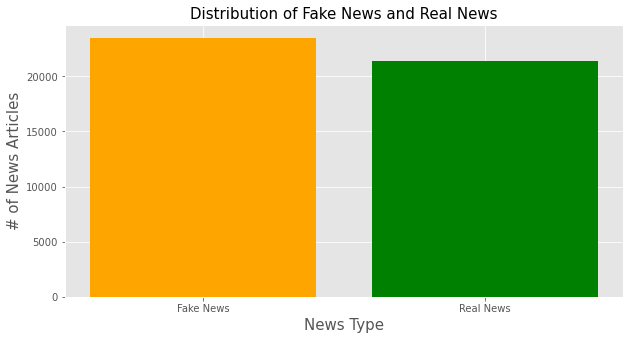

In [9]:
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df), color='orange')
plt.bar('Real News', len(real_df), color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('# of News Articles', size=15)

In [10]:
print('Difference in news articles:',len(fake_df)-len(real_df))

Difference in news articles: 2064


In [11]:
news_df = pd.concat([fake_df, real_df], ignore_index=True, sort=False)
news_df

,title,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0
...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",1
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,1
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,1


Combining the title with the text, it is much easier to process this way. 

In [12]:
news_df['text'] = news_df['title'] + news_df['text']
news_df.drop('title', axis=1, inplace=True)

Split into training and testing 

In [13]:
features = news_df['text']
targets = news_df['class']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

Normalizing our data: lower case, get rid of extra spaces, and url links. 

In [14]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [15]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

Convert text to vectors, our classifier only takes numerical data. 

In [16]:
# tokenize the text into vectors 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Apply padding so we have the same length for each article 

In [17]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

Building the RNN.

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 390,401
Trainable params: 390,401
Non-trainable params: 0
__________________________________________________

We are going to use early stop, which stops when the validation loss no longer improve.

In [19]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1078/1078 [==============================] - 48s 45ms/step - loss: 0.2651 - accuracy: 0.8691 - val_loss: 0.0839 - val_accuracy: 0.9680
Epoch 2/10
1078/1078 [==============================] - 47s 44ms/step - loss: 0.0640 - accuracy: 0.9826 - val_loss: 0.0594 - val_accuracy: 0.9727
Epoch 3/10
1078/1078 [==============================] - 46s 43ms/step - loss: 0.0315 - accuracy: 0.9922 - val_loss: 0.0367 - val_accuracy: 0.9883
Epoch 4/10
1078/1078 [==============================] - 47s 44ms/step - loss: 0.0205 - accuracy: 0.9951 - val_loss: 0.0629 - val_accuracy: 0.9852
Epoch 5/10
1078/1078 [==============================] - 48s 44ms/step - loss: 0.0125 - accuracy: 0.9972 - val_loss: 0.0295 - val_accuracy: 0.9916
Epoch 6/10
1078/1078 [==============================] - 47s 44ms/step - loss: 0.0091 - accuracy: 0.9982 - val_loss: 0.0487 - val_accuracy: 0.9850
Epoch 7/10
1078/1078 [==============================] - 47s 44ms/step - loss: 0.0082 - accuracy: 0.9981 - val_loss: 0.0331 -

Visualize our training over time 

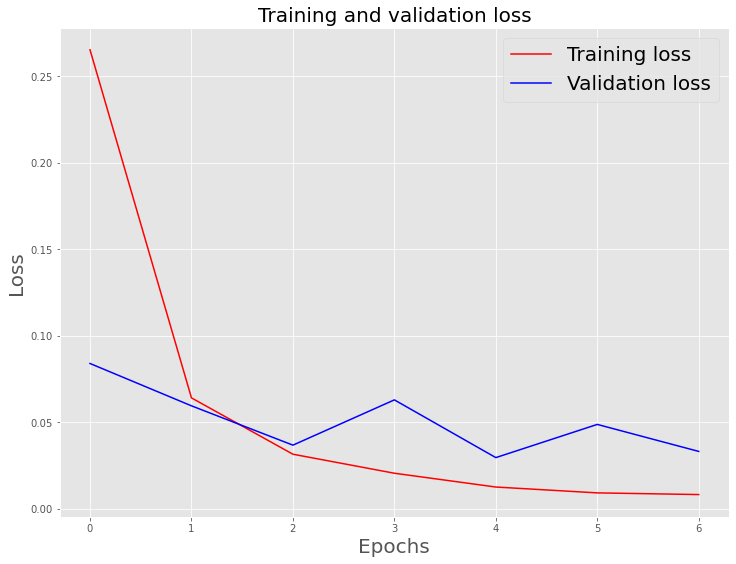

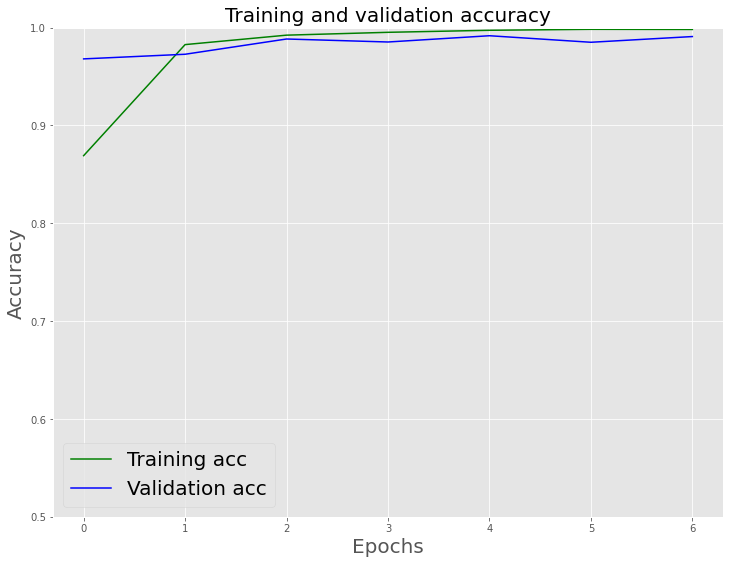

In [20]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

Evaluate the testing set 

In [21]:
model.evaluate(X_test, y_test)

281/281 [==============================] - 5s 18ms/step - loss: 0.0342 - accuracy: 0.9914


[0.03422863781452179, 0.9914253950119019]

In [22]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [23]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9914253897550112
Precision on testing set: 0.9884205650764243
Recall on testing set: 0.9937136204889406


Confusion matrix 

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

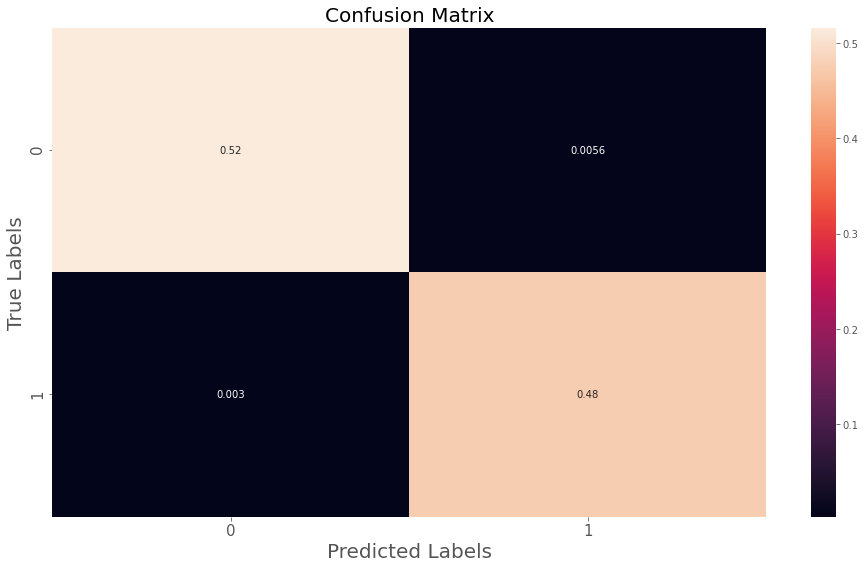

In [24]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

Saves the weights for visualiation

In [25]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 32)


In [26]:
word_index = list(tokenizer.word_index.keys())
word_index = word_index[:max_vocab-1]

Write to file so we can use tensorflow's embedding projector to visualize what our network learned. This is only based on the fake news dataset. 

In [27]:
import io

out_v = io.open('fakenews_vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('fakenews_meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(word_index):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

Embedding Projector: http://projector.tensorflow.org/
<br>Picture credits: https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding.jpg?raw=1

![](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding.jpg?raw=1)